# Tutorial VQE with Qiskit Aer Primitives

Qiskit Aer Primitives per simulazioni in locale con e senza rumore. Si possono introdurre modelli di rumore personalizzati, oppure utilizzare quelli basati su specifici hardware. Documentazione: https://qiskit.github.io/qiskit-aer/apidocs/aer_noise.html

Si usa VQE per determinare l'energia di stato fondamentale per una certa hamiltoniana. In questo caso, si usa un seti di operatori di Pauli (**SparsePauliOp**), forniti da Qiskit Nature per la molecola di H2.

In [8]:
# definisco l'operatore da studiare
from qiskit.quantum_info import SparsePauliOp

H2_op = SparsePauliOp.from_list(
    [
        ("II", -1.052373245772859),
        ("IZ", 0.39793742484318045),
        ("ZI", -0.39793742484318045),
        ("ZZ", -0.01128010425623538),
        ("XX", 0.18093119978423156), # originally: 0.18093119978423156
    ]
)

print(f"Number of qubits: {H2_op.num_qubits}")

Number of qubits: 2


In [9]:
# definisco il numero di shots per vedere come cambiano i risultati
shots = 10000

## 0 - Valore di riferimento con algoritmo classico

Il problema è semplice: in questa fase preliminare si utilizza **NumPyMinimumEigensolver** per calcolare un valore di riferimento dell'energia minima.

In [10]:
from qiskit_algorithms import NumPyMinimumEigensolver

numpy_solver = NumPyMinimumEigensolver()
result = numpy_solver.compute_minimum_eigenvalue(operator=H2_op)
ref_value = result.eigenvalue.real # membro che contiene il valore del minimo dell'energia
print(f"Reference value: {ref_value:.5f}")

Reference value: -1.85728


## 0.1 - Ansatz

In [11]:
# Definisco l'ansatz hardware efficient TwoLocal e scelgo l'ottimizzatore SPSA
from qiskit.circuit.library import TwoLocal
from qiskit_algorithms.optimizers import SPSA

iterations = 125
ansatz = TwoLocal(rotation_blocks="ry", entanglement_blocks="cz")
spsa = SPSA(maxiter=iterations) 

## 1 - Simulazione Noiseless

«Fixed seed for the run and transpilation to obtain reproducible results»

In [12]:
# vettori che andranno a raccogliere i risultati delle varie iterazioni dell'algoritmo
counts = []
values = []


def store_intermediate_result(eval_count, parameters, mean, std):
    counts.append(eval_count)
    values.append(mean)

In [13]:
# define Aer Estimator for noiseless statevector simulation 
from qiskit_algorithms.utils import algorithm_globals
from qiskit_aer.primitives import Estimator as AerEstimator 

seed = 170
algorithm_globals.random_seed = seed 

noiseless_estimator = AerEstimator(
    run_options={"seed": seed, "shots": shots}, 
    transpile_options={"seed_transpiler": seed},
)

In [14]:
# instantiate and run VQE
from qiskit_algorithms import VQE

vqe = VQE(noiseless_estimator, ansatz, optimizer=spsa, callback=store_intermediate_result) 
# l'oggetto callback can access the intermediate data at each optimization step
result = vqe.compute_minimum_eigenvalue(operator=H2_op)

print(f"VQE on Aer qasm simulator (no noise): {result.eigenvalue.real:.5f}")
print(f"Distance from reference energy value is {(result.eigenvalue.real - ref_value):.5f}") 

VQE on Aer qasm simulator (no noise): -1.85774
Distance from reference energy value is -0.00047


Uso i dati raccolti in **store_intermediate_result** per produrre un grafico che mostra l'ottimizzazione del risultato durante le chiamate dell'algoritmo.

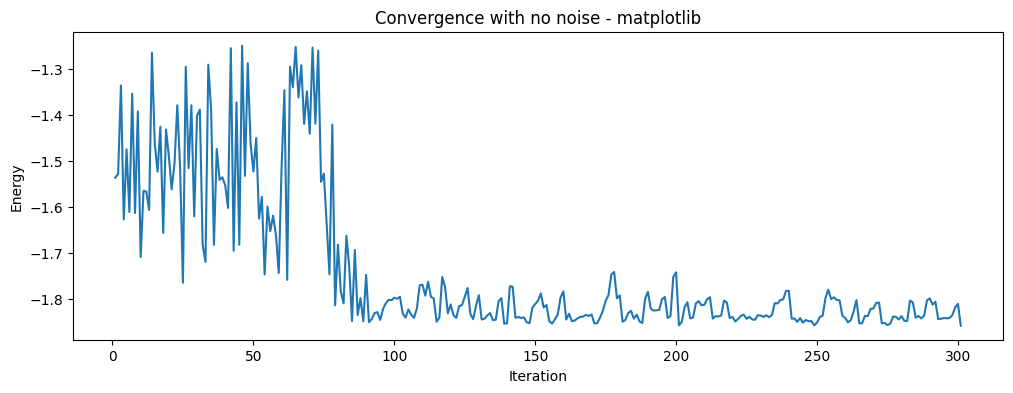

Text(0.5, 1.0, 'Convergence with no noise - pylab')

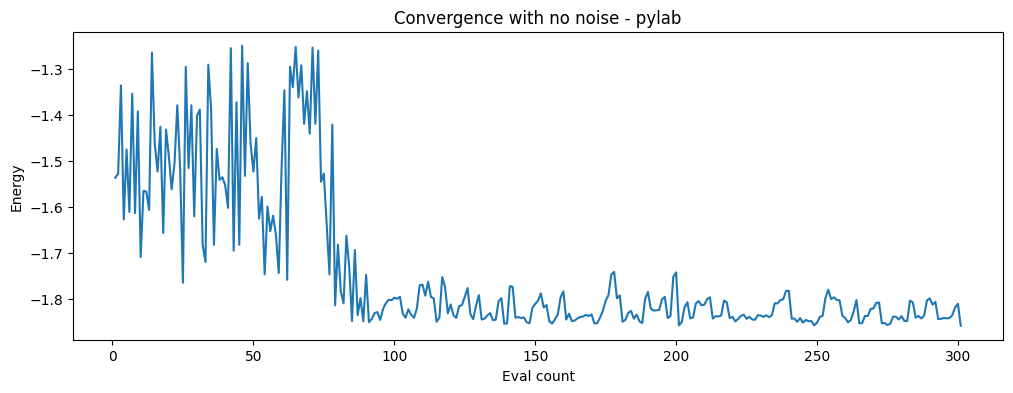

In [15]:
# uso anche matplotlib oltre che il suggerito pylab per sperimentare
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (12,4)
plt.plot(counts, values) # non serve il marker
plt.xlabel('Iteration')
plt.ylabel('Energy')
plt.title("Convergence with no noise - matplotlib")
plt.show()

import pylab # non c'è niente di diverso perché pyplot è un modulo di matplotlib

pylab.rcParams["figure.figsize"] = (12, 4)
pylab.plot(counts, values)
pylab.xlabel("Eval count")
pylab.ylabel("Energy")
pylab.title("Convergence with no noise - pylab")

# non mi pare ci siano differenze

## 2 - Simulazione con Rumore

Si va a dichiarare un oggetto **GenericBackendV2**, cioè un device fittizio. A questo si può associare il modello di rumore desiderato, oltre che la configurazione dei qubit [coupling map].

In [16]:
from qiskit_aer.noise import NoiseModel
from qiskit.providers.fake_provider import GenericBackendV2

coupling_map = [(0, 1), (1, 2), (2, 3), (3, 4)]
device = GenericBackendV2(num_qubits=5, coupling_map=coupling_map, seed=54)

noise_model = NoiseModel.from_backend(device)

print(noise_model)

NoiseModel:
  Basis gates: ['cx', 'delay', 'id', 'measure', 'reset', 'rz', 'sx', 'x']
  Instructions with noise: ['cx', 'sx', 'measure', 'id', 'x']
  Qubits with noise: [0, 1, 2, 3, 4]
  Specific qubit errors: [('cx', (0, 1)), ('cx', (1, 2)), ('cx', (2, 3)), ('cx', (3, 4)), ('id', (0,)), ('id', (1,)), ('id', (2,)), ('id', (3,)), ('id', (4,)), ('sx', (0,)), ('sx', (1,)), ('sx', (2,)), ('sx', (3,)), ('sx', (4,)), ('x', (0,)), ('x', (1,)), ('x', (2,)), ('x', (3,)), ('x', (4,)), ('measure', (0,)), ('measure', (1,)), ('measure', (2,)), ('measure', (3,)), ('measure', (4,))]


Quindi si esegue VQE con Aer Estimator passando **noise_model** nelle **backend_options**. Non è necessario re-istanziare l'oggetto vqe, si può riutilizzare quello precedente.

In [17]:
noisy_estimator = AerEstimator(
    backend_options={
        "method": "density_matrix",
        "coupling_map": coupling_map,
        "noise_model": noise_model,
    },
    run_options={"seed": seed, "shots": shots},
    transpile_options={"seed_transpiler": seed},
)

In [18]:
# devo resettare i vettori 
counts = []
values = []

# RIUTILIZZO vqe:
# cambio l'estimator
vqe.estimator = noisy_estimator

result1 = vqe.compute_minimum_eigenvalue(operator=H2_op)

# viene fuori che è distante il doppio
print(f"VQE on Aer qasm simulator (with noise): {result1.eigenvalue.real:.5f}")
print(f"Distance from reference energy value is {(result1.eigenvalue.real - ref_value):.5f}") 

# dopo provo a cambiare i parametri del noisy_estimator

VQE on Aer qasm simulator (with noise): -1.84092
Distance from reference energy value is 0.01635


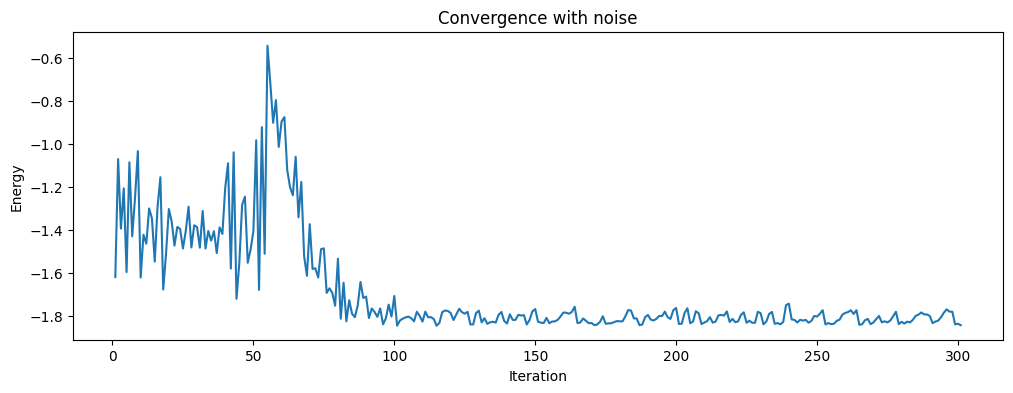

In [19]:
if counts or values:
    plt.rcParams["figure.figsize"] = (12, 4)
    plt.plot(counts, values)
    plt.xlabel("Iteration")
    plt.ylabel("Energy")
    plt.title("Convergence with noise")
else:
    print("I vettori di dati intermedi non sono stati riempiti")

## 3 - Ripeto ma con noise model di un hardware 

Ripeto, ma stavolta inserisco il layout e il noise model di ibm_brisbane

In [27]:
from qiskit_ibm_provider import IBMProvider # c'è da scaricare qiskit_ibm_provider 

# prendo il device che desidero
provider = IBMProvider()
backend = provider.get_backend('ibm_brisbane')

# Estraggo il modello di rumore dal backend reale
noise_model_brisbane = NoiseModel.from_backend(backend)

# E le altre proprietà del backend
coupling_map_brisbane = backend.configuration().coupling_map
basis_gates = noise_model.basis_gates

# Dovrebbe essere a posto, ora creo un nuovo Aer_simulator e lo faccio girare con vqe

In [28]:
# Nuovo Estimator
noisy_brisbane_estimator = AerEstimator(
    backend_options={
        "method": "density_matrix",
        "coupling_map": coupling_map_brisbane,
        "noise_model": noise_model_brisbane,
    },
    run_options={"seed": seed, "shots": shots},
    transpile_options={"seed_transpiler": seed},
)

In [29]:
# RIUTILIZZO vqe:
# cambio l'estimator
vqe.estimator = noisy_brisbane_estimator

result2 = vqe.compute_minimum_eigenvalue(operator=H2_op)

# viene fuori che è distante il doppio
print(f"VQE on Aer qasm simulator (with ibm_brisbane noise): {result2.eigenvalue.real:.5f}")
print(f"Distance from reference energy value is {(result2.eigenvalue.real - ref_value):.5f}") 

# oltre il minuto di esecuzione

VQE on Aer qasm simulator (with ibm_brisbane noise): -1.77857
Distance from reference energy value is 0.07871


In [33]:
print ("brisbane ", result2.eigenvalue.real, "#Delta ", result2.eigenvalue.real - ref_value)
print ("noisy ", result1.eigenvalue.real, "#Delta ", result1.eigenvalue.real - ref_value)
print ("noiseless", result.eigenvalue.real, "#Delta ", result.eigenvalue.real - ref_value)

brisbane  -1.7785680411740172 #Delta  0.07870698902836337
noisy  -1.840923811973938 #Delta  0.016351218228442654
noiseless -1.8577442312429564 #Delta  -0.00046920104057579515


In [ ]:
# circa 4 volte PEGGIO DEL NOISY DI PRIMA